In [1]:
# Cell 1
import os, json, pathlib, random
from typing import List, Dict, Tuple

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ---------------- Config ----------------
DEVICE = torch.device("cuda")
INPUT_SIZE = (64, 512)
BATCH_SIZE = 64

SPLITS_DIR = r"C:\Users\awais\OneDrive\Desktop\Thesis\splits\Eyes\FIHR"
DATASETS = {
    "Pakistan": r"C:\Users\awais\OneDrive\Desktop\Thesis\Pakistan\PakIris_Normalized_Aug",
    "China":    r"C:\Users\awais\OneDrive\Desktop\Thesis\China\CASIA-Iris-Interval_Normalized_Aug",
    "Czech":    r"C:\Users\awais\OneDrive\Desktop\Thesis\Czech\CzechIris_Normalized_Enhanced_FIHR",
    "India":    r"C:\Users\awais\OneDrive\Desktop\Thesis\India\IITD_Normalized",
    "Iraq":     r"C:\Users\awais\OneDrive\Desktop\Thesis\Iraq\AMF_Normalized_Enhanced_FIHR",
    "Malaysia": r"C:\Users\awais\OneDrive\Desktop\Thesis\Malaysia\MMU_Normalized_Enhanced_FIHR",
    "Iran":     r"C:\Users\awais\OneDrive\Desktop\Thesis\Iran\Iris_Normalized_Enhanced_FIHR",
}

EMBED_DIM = 256


In [2]:
# Cell 2
def load_json_split(dataset_name: str, dataset_root: str):
    fp = os.path.join(SPLITS_DIR, f"{dataset_name.lower()}_split.json")
    with open(fp, "r", encoding="utf-8") as f:
        data = json.load(f)

    def finalize(lst):
        items = []
        for itm in lst:
            if isinstance(itm, (list, tuple)):
                path, lbl = itm[0], itm[1] if len(itm) > 1 else None
            elif isinstance(itm, dict):
                path = itm.get("path") or itm.get("image") or next(iter(itm.values()))
                lbl  = itm.get("label")
            else:
                path, lbl = itm, None
            abs_path = path if os.path.isabs(path) else os.path.join(dataset_root, path)
            if lbl is None:
                lbl = pathlib.Path(abs_path).parent.name
            items.append((abs_path, lbl))
        return items

    train = finalize(data["train"])
    val   = finalize(data["val"])
    test  = finalize(data["test"])
    classes = sorted({l for _, l in train + val + test})
    return {"train": train, "val": val, "test": test, "classes": classes}


def estimate_mean_std(items: List[Tuple[str,str]], max_samples: int = 512):
    sel = items if len(items) <= max_samples else random.sample(items, max_samples)
    m = 0.0; s2 = 0.0; n = 0
    for p,_ in sel:
        with Image.open(p) as im:
            arr = np.asarray(im.convert("L"), dtype=np.float32) / 255.0
        m_batch = arr.mean(); s2_batch = arr.var(); k = arr.size
        new_n = n + k
        delta = m_batch - m
        m = m + delta * (k / new_n)
        s2 = (n*s2 + k*s2_batch + (delta**2)*n*k/new_n) / new_n
        n = new_n
    return float(m), float(np.sqrt(max(s2, 1e-8)))


@torch.no_grad()
def compute_embeddings(model, items, mean, std, batch_size=BATCH_SIZE):
    """
    Same behaviour as in your training code:
    - grayscale
    - resize to (64, 512)
    - normalize with dataset-specific mean/std
    - L2-normalized embeddings from the FL model
    """

    tx = transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([mean], [std]),
    ])

    class EvalSet(Dataset):
        def __init__(self, items): self.items = items
        def __len__(self): return len(self.items)
        def __getitem__(self, i):
            p, l = self.items[i]
            x = tx(Image.open(p).convert("L"))
            return x, l

    loader = DataLoader(EvalSet(items), batch_size=batch_size, shuffle=False)
    model.eval()
    feats, labels = [], []
    for xb, yb in loader:
        z = model(xb.to(DEVICE)).cpu()
        feats.append(z)
        labels.extend(yb)
    return torch.cat(feats).numpy(), np.array(labels)


# --------- Metrics with interpolation (EER, TAR@FAR) ----------

def _eer_from_fpr_tpr_interp(fpr, tpr):
    """
    EER via interpolation between the two points where fpr-fnr changes sign.
    Falls back to closest point if monotonic.
    """
    fnr = 1.0 - tpr
    diff = fpr - fnr

    # If never crosses zero, fall back to nearest point
    if np.all(diff >= 0) or np.all(diff <= 0):
        i = int(np.nanargmin(np.abs(diff)))
        return float(max(fpr[i], fnr[i]))

    # find indices where sign changes
    idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
    i0 = idx[0]
    i1 = i0 + 1

    # linear interpolation for EER
    x0, x1 = fpr[i0], fpr[i1]
    y0, y1 = fnr[i0], fnr[i1]
    # we want fpr == fnr on the segment between (x0,y0) and (x1,y1)
    # parameterize both as linear in t, solve x(t) = y(t)
    # but simpler: interpolate diff to zero
    d0, d1 = diff[i0], diff[i1]
    t = d0 / (d0 - d1 + 1e-12)
    eer = x0 + t * (x1 - x0)
    return float(eer)


def _tar_at_far_interp(fpr, tpr, far):
    """
    TAR at given FAR using linear interpolation on (fpr, tpr).
    """
    fpr = np.asarray(fpr)
    tpr = np.asarray(tpr)

    if far <= fpr[0]:
        return float(tpr[0])
    if far >= fpr[-1]:
        return float(tpr[-1])

    idx1 = int(np.searchsorted(fpr, far))
    idx0 = idx1 - 1

    x0, x1 = fpr[idx0], fpr[idx1]
    y0, y1 = tpr[idx0], tpr[idx1]

    if x1 == x0:
        return float(y0)

    alpha = (far - x0) / (x1 - x0)
    tar = y0 + alpha * (y1 - y0)
    return float(tar)


def evaluate_embeddings(feats, labels):
    """
    Given embeddings and identity labels, computes:
    - ROC-AUC
    - EER (interpolated)
    - TAR@FAR=0.01 and 0.001 (interpolated)
    and also returns the ROC curve (fpr, tpr).
    """
    if len(labels) < 2:
        return {
            "roc_auc": float("nan"),
            "eer": float("nan"),
            "tar1": float("nan"),
            "tar01": float("nan"),
            "fpr": None,
            "tpr": None,
        }

    # cosine similarities of L2-normalized embeddings
    Z = torch.tensor(feats, dtype=torch.float32)
    Z = F.normalize(Z, dim=1)
    S = (Z @ Z.t()).numpy()

    m = labels.reshape(-1,1) == labels.reshape(1,-1)
    iu = np.triu_indices_from(S, 1)
    y_true = m[iu].astype(np.uint8)
    y_score = S[iu]

    if len(np.unique(y_true)) < 2:
        return {
            "roc_auc": float("nan"),
            "eer": float("nan"),
            "tar1": float("nan"),
            "tar01": float("nan"),
            "fpr": None,
            "tpr": None,
        }

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = float(roc_auc_score(y_true, y_score))
    eer = _eer_from_fpr_tpr_interp(fpr, tpr)
    tar1 = _tar_at_far_interp(fpr, tpr, 0.01)
    tar01 = _tar_at_far_interp(fpr, tpr, 0.001)

    return {
        "roc_auc": auc,
        "eer": eer,
        "tar1": tar1,
        "tar01": tar01,
        "fpr": fpr,
        "tpr": tpr,
    }


In [ ]:
# Cell 3
try:
    import timm
except Exception as e:
    print("timm not available:", e)
    timm = None

class SwinV2_Tiny_Siamese(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM):
        super().__init__()
        assert timm is not None, "timm is required."
        m = timm.create_model(
            "swinv2_tiny_window8_256",
            pretrained=False,
            num_classes=0,
            in_chans=1,
            img_size=INPUT_SIZE,
        )
        feat_dim = m.num_features
        self.backbone = m
        self.proj = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.GELU(),
            nn.LayerNorm(feat_dim),
            nn.Linear(feat_dim, embed_dim),
        )
    def forward(self, x):
        f = self.backbone(x)
        z = self.proj(f)
        return F.normalize(z, p=2, dim=1)


FL_CKPT = r"C:\Users\awais\OneDrive\Desktop\Thesis\Eye_Results\FL_Stage3\FHIR_POLY_EER_best.pt"

ckpt = torch.load(FL_CKPT, map_location=DEVICE)

fl_model = SwinV2_Tiny_Siamese().to(DEVICE)
fl_model.load_state_dict(ckpt["global_model"], strict=True)

print("Loaded FL model from:", FL_CKPT)
print("  strategy:", ckpt.get("strategy"))
print("  best_round:", ckpt.get("best_round"))
print("  best_macro_eer:", ckpt.get("best_macro_eer"))
print("  poly_degree:", ckpt.get("poly_degree"))
print("  warmup_rounds:", ckpt.get("warmup_rounds"))


Loaded FL model from: C:\Users\awais\OneDrive\Desktop\Thesis\Eye_Results\FL_Stage3\FHIR_POLY_EER_best.pt
  strategy: FHIR-POLY-EER
  best_round: 204
  best_macro_eer: 0.004408648694933183
  poly_degree: 2
  warmup_rounds: 50


In [5]:
# Cell 4
splits = {d: load_json_split(d, r) for d, r in DATASETS.items()}

mean_std = {}
for d in DATASETS.keys():
    m, s = estimate_mean_std(splits[d]["train"])
    mean_std[d] = (m, s)
    print(f"{d}: mean={m:.3f}, std={s:.3f}")

roc_data_fl = {}    # dataset -> (fpr, tpr, auc)
metrics_fl  = {}    # dataset -> dict with roc_auc, eer, tar1, tar01

for d in DATASETS.keys():
    print(f"\nComputing FL metrics for {d}...")
    mean, std = mean_std[d]

    feats, labels = compute_embeddings(
        fl_model,
        splits[d]["test"],
        mean,
        std
    )

    m = evaluate_embeddings(feats, labels)
    metrics_fl[d] = m

    fpr, tpr, auc = m["fpr"], m["tpr"], m["roc_auc"]
    roc_data_fl[d] = (fpr, tpr, auc)

    print(
        f"  AUC = {m['roc_auc']:.4f}, "
        f"EER = {m['eer']:.4f}, "
        f"TAR@1% = {m['tar1']:.4f}, "
        f"TAR@0.1% = {m['tar01']:.4f}"
    )


Pakistan: mean=0.356, std=0.125
China: mean=0.514, std=0.268
Czech: mean=0.366, std=0.175
India: mean=0.268, std=0.196
Iraq: mean=0.367, std=0.168
Malaysia: mean=0.324, std=0.185
Iran: mean=0.324, std=0.187

Computing FL metrics for Pakistan...
  AUC = 0.9996, EER = 0.0093, TAR@1% = 0.9931, TAR@0.1% = 0.9653

Computing FL metrics for China...
  AUC = 0.9997, EER = 0.0078, TAR@1% = 0.9932, TAR@0.1% = 0.9326

Computing FL metrics for Czech...
  AUC = 0.9933, EER = 0.0556, TAR@1% = 0.9167, TAR@0.1% = 0.8056

Computing FL metrics for India...
  AUC = 0.9995, EER = 0.0088, TAR@1% = 0.9912, TAR@0.1% = 0.9824

Computing FL metrics for Iraq...
  AUC = 0.9998, EER = 0.0100, TAR@1% = 0.9900, TAR@0.1% = 0.9800

Computing FL metrics for Malaysia...
  AUC = 0.9847, EER = 0.0357, TAR@1% = 0.5000, TAR@0.1% = 0.3125

Computing FL metrics for Iran...
  AUC = 0.9993, EER = 0.0150, TAR@1% = 0.9808, TAR@0.1% = 0.8974


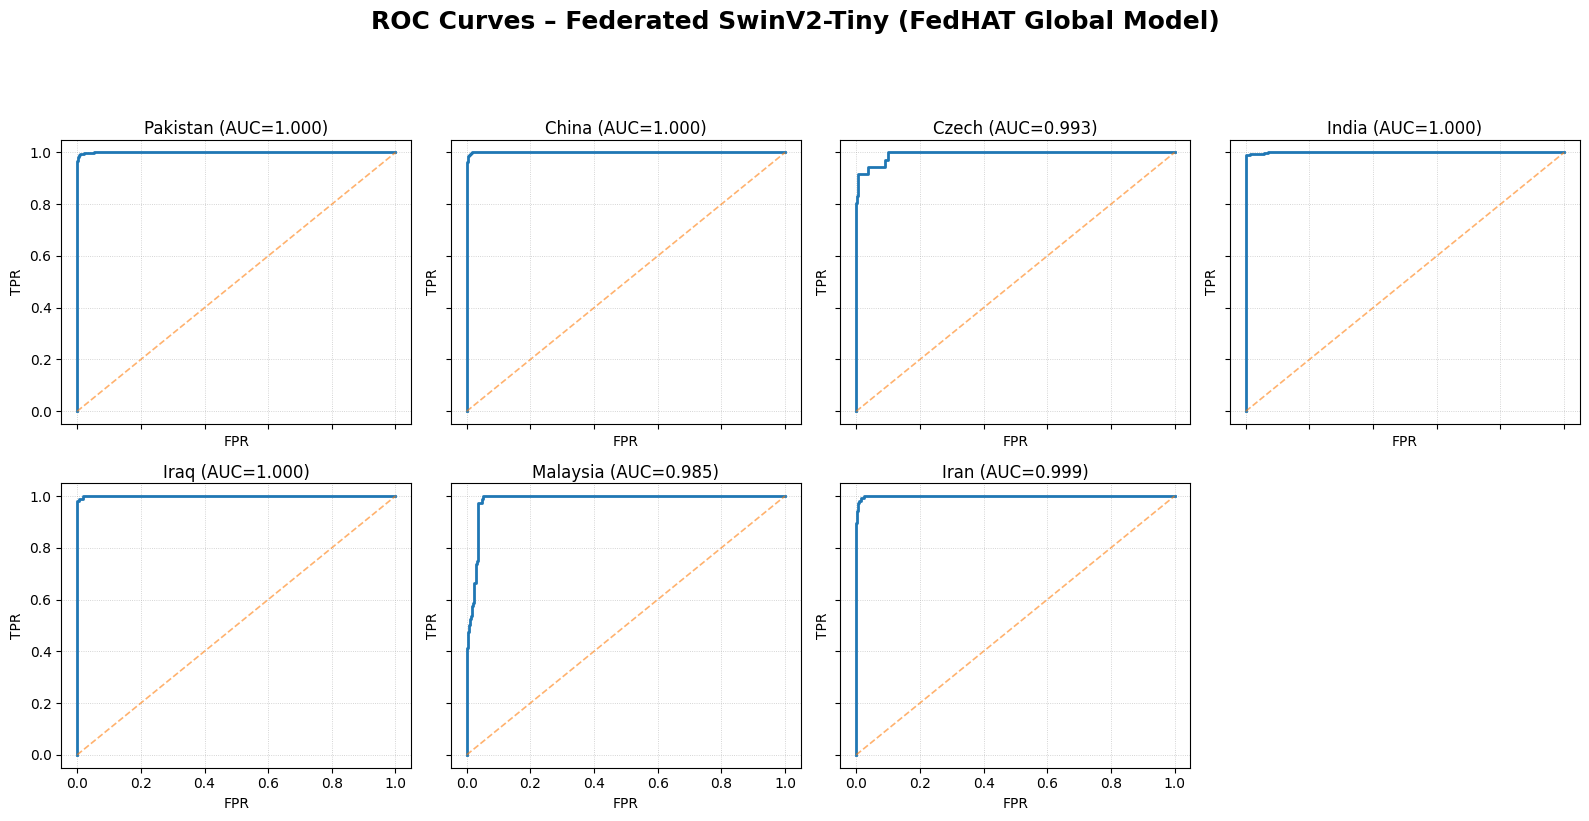

In [6]:
# Cell 5
import matplotlib.pyplot as plt

datasets_order = ["Pakistan", "China", "Czech", "India", "Iraq", "Malaysia", "Iran"]

plt.style.use("default")
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
axes = axes.ravel()

# Plot only the datasets you have
for ax, d in zip(axes[:len(datasets_order)], datasets_order):
    fpr, tpr, auc = roc_data_fl[d]

    ax.plot(fpr, tpr, linewidth=2.0, color="#1f77b4")
    ax.plot([0,1], [0,1], linestyle="--", linewidth=1.2, color="#ff7f0e", alpha=0.6)

    ax.set_title(f"{d} (AUC={auc:.3f})", fontsize=12, pad=4)
    ax.set_xlabel("FPR", fontsize=10)
    ax.set_ylabel("TPR", fontsize=10)
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)

# Hide unused axes
for ax in axes[len(datasets_order):]:
    ax.axis("off")

# Global title
fig.suptitle(
    "ROC Curves – Federated SwinV2-Tiny (FedHAT Global Model)",
    fontsize=18,
    fontweight="bold",
    y=1.02
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
